In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012",split = 'train')

In [ ]:
print(dataset)

Dataset({
    features: ['image', 'mask'],
    num_rows: 1464
})


In [ ]:
validation_dataset = load_dataset("nateraw/pascal-voc-2012", split='val')
print(validation_dataset)

Dataset({
    features: ['image', 'mask'],
    num_rows: 1449
})


In [ ]:
# 첫 번째 데이터 항목에 접근
first_data = dataset[0]
print(first_data)

# 이미지와 마스크 데이터에 접근
image, mask = first_data['image'], first_data['mask']


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x281 at 0x7B2B33BD8DC0>, 'mask': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x281 at 0x7B2B33BD8C10>}


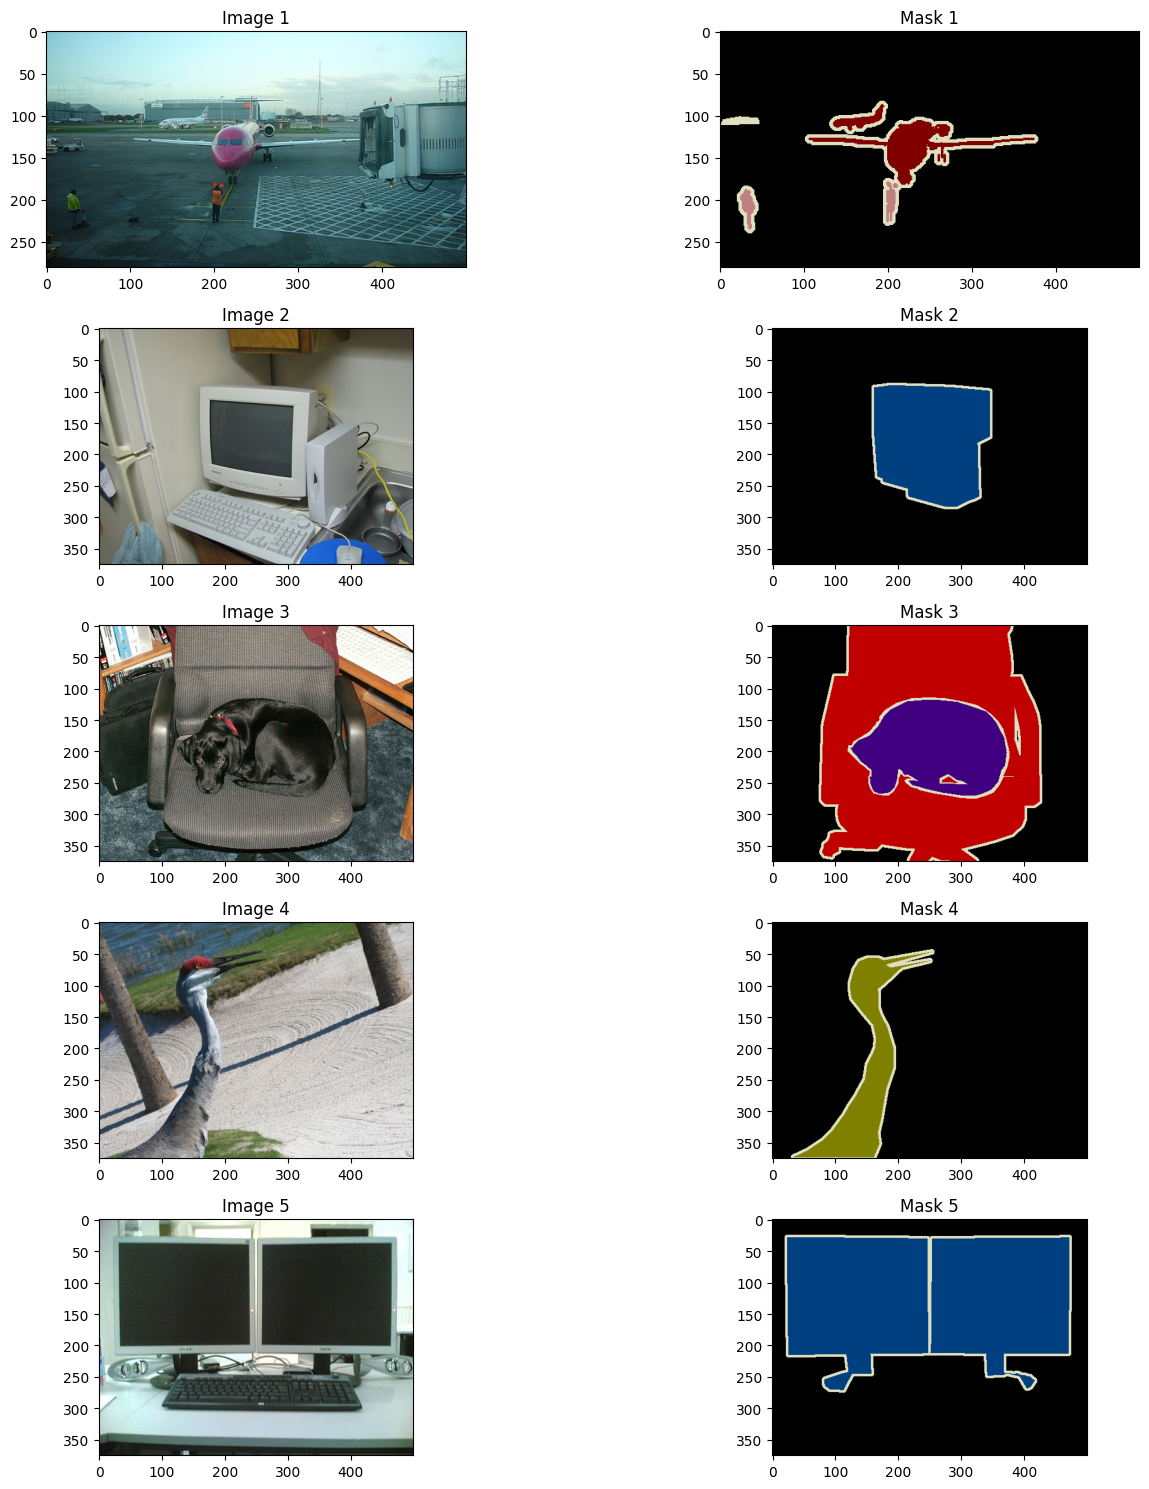

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 5개의 데이터 항목을 시각화하는 함수
def visualize_dataset(dataset, num_items=5):
    plt.figure(figsize=(15, num_items * 3))

    for i in range(num_items):
        # 첫 번째 데이터 항목에 접근
        data = dataset[i]
        image, mask = data['image'], data['mask']

        plt.subplot(num_items, 2, 2 * i + 1)
        plt.imshow(image)
        plt.title(f'Image {i+1}')

        plt.subplot(num_items, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i+1}')

    plt.tight_layout()
    plt.show()

# 데이터셋에서 5개의 데이터 항목을 시각화합니다.
visualize_dataset(dataset, num_items=5)


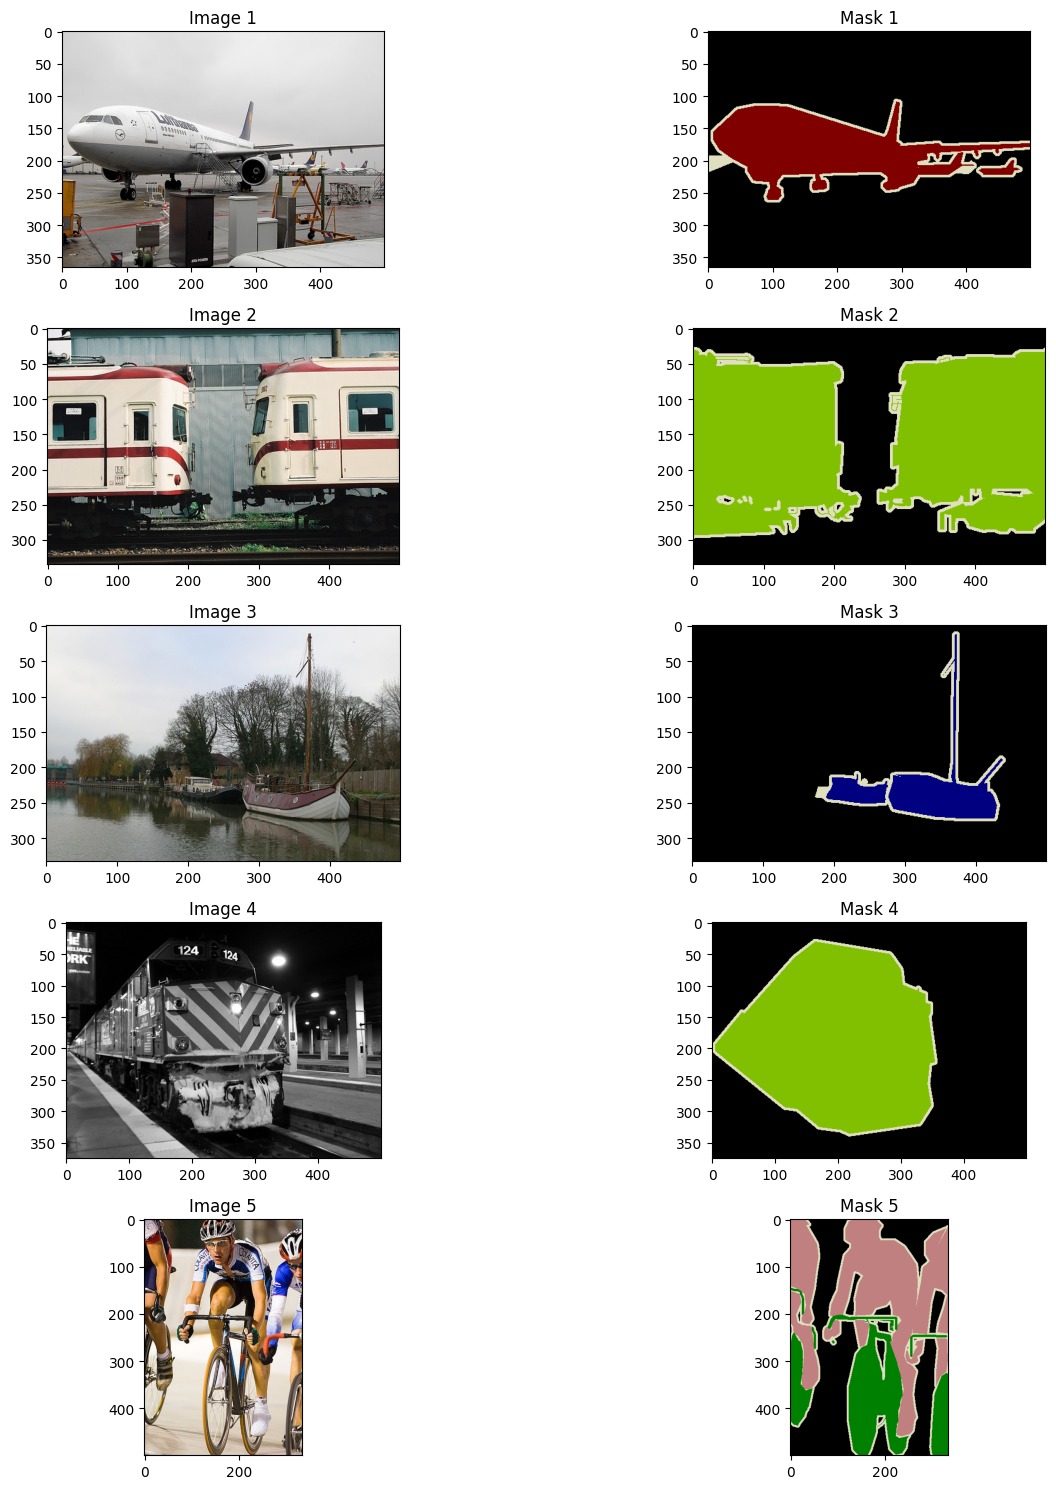

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize the dataset
def visualize_dataset(dataset, num_items=5):
    plt.figure(figsize=(15, num_items * 3))

    for i in range(num_items):
        # Access the ith data item
        data = dataset[i]
        image, mask = data['image'], data['mask']

        plt.subplot(num_items, 2, 2 * i + 1)
        plt.imshow(image)
        plt.title(f'Image {i+1}')

        plt.subplot(num_items, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i+1}')

    plt.tight_layout()
    plt.show()

# Visualize 5 data items from the validation dataset
visualize_dataset(validation_dataset, num_items=5)


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split


import os
import copy
import math

from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import utils

from PIL import Image, ImageDraw

from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

#augmentation

In [ ]:
def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
            RandomSizedCrop(
                min_max_height=(100, 300),  # 이 값을 실제 이미지 크기에 맞게 조정
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(  # 입력이미지를 224x224로 resize
                width=224,
                height=224
            )
        ])
    return Compose([  # 테스트용 데이터일 경우에는 224x224로 resize만 수행
        Resize(
            width=224,
            height=224
        )
    ])

# 나머지 코드는 동일하게 유지합니다.


In [ ]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)

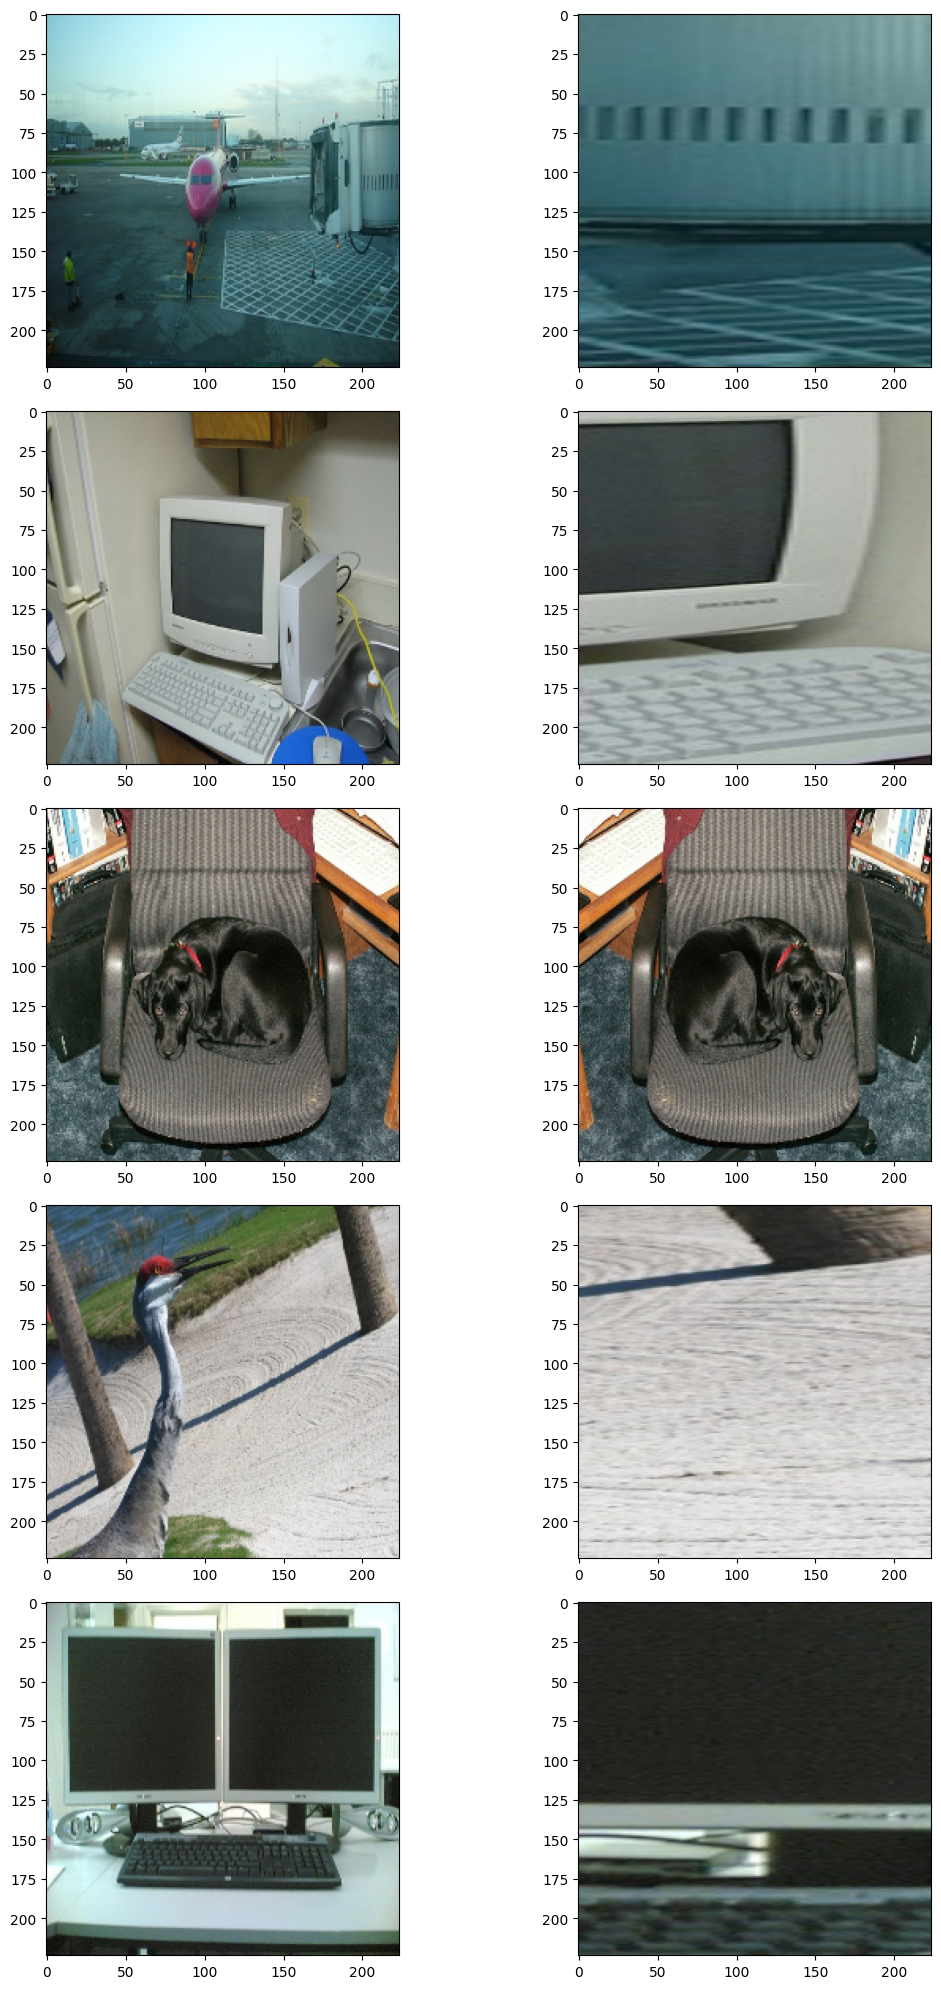

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 20))
for i in range(5):
    # 이미지 데이터에 바로 접근
    image = dataset[i]['image']

    # PIL 이미지를 NumPy 배열로 변환
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    image_data = {"image": image}
    resized = augmentation_test(**image_data)  # w,h 만 변경
    processed = augmentation_train(**image_data)  # aug 진행

    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.tight_layout()
plt.show()


In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 image_data,  # 이미지 데이터를 직접 전달합니다.
                 batch_size=8,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        self.image_data = image_data  # 이미지 데이터를 인스턴스 변수로 저장합니다.
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # 이미지 데이터의 개수를 계산합니다.
        self.num_samples = len(self.image_data)

    def __len__(self):
        # Generator의 length로서 전체 데이터 개수를 batch_size로 나누고 소수점을 올림합니다.
        return math.ceil(self.num_samples / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고 출력은 semantic label입니다.
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        end_idx = min(end_idx, self.num_samples)  # 마지막 배치 처리

        batch_data = self.image_data[start_idx:end_idx]
        inputs = np.zeros([end_idx - start_idx, *self.img_size])
        outputs = np.zeros([end_idx - start_idx, *self.output_size])

        for i, data in enumerate(batch_data):
            _input = data['image']
            _output = data['mask']
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]

        return inputs, outputs

    def on_epoch_end(self):
        if self.is_train:
            # 학습 중인 경우 데이터를 섞습니다.
            np.random.shuffle(self.image_data)

In [ ]:
train_preproc = build_augmentation(is_train=True)
test_preproc = build_augmentation(is_train=False)

In [ ]:
# 이미지 데이터를 KittiGenerator에 전달
train_generator = KittiGenerator(
    image_data=dataset,  # 이미지 데이터를 직접 전달
    augmentation=train_preproc,
    is_train=True
)

test_generator = KittiGenerator(
    image_data=validation_dataset,  # 이미지 데이터를 직접 전달
    augmentation=test_preproc,
    is_train=False
)

#DeepLab V3 & DeepLab V3+

###DeepLab V3+

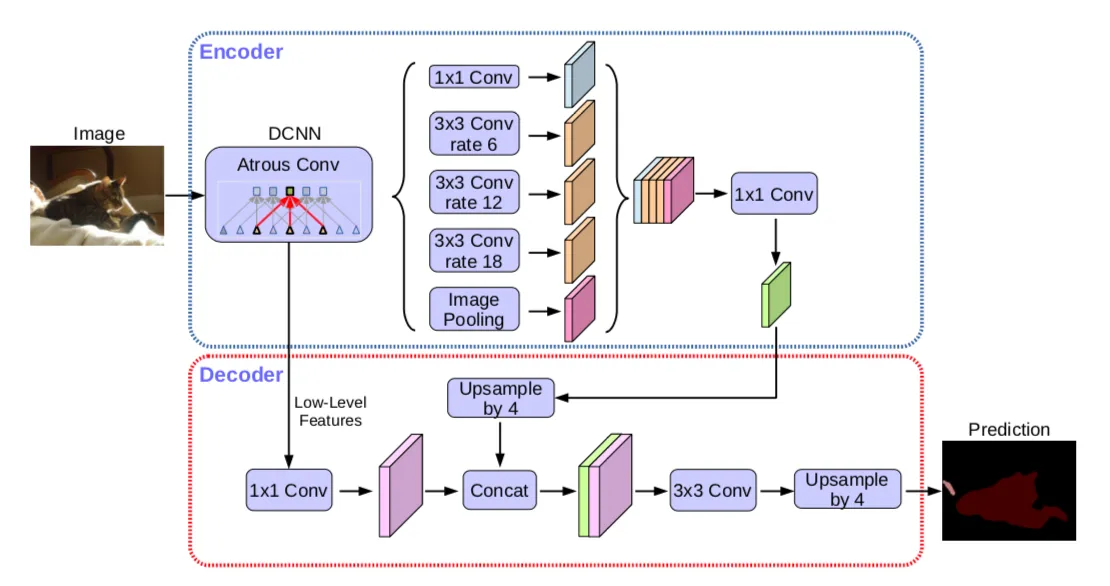

In [ ]:
def dataset_replication_callback(data_parallel):
    assert isinstance(data_parallel, DataParallel)

    old_replicate = data_parallel.replicate

    @functools.wraps(old_replicate)
    def new_replicate(module, device_ids):
        modules = old_replicate(module, device_ids)
        execute_replication_callbacks(modules)
        return modules

    data_parallel.replicate = new_replicate


In [ ]:
import torch
import torch.nn.functional as F
from torch.nn.modules.batchnorm import _BatchNorm
from torch.nn.parallel._functions import ReduceAddCoalesced, Broadcast
import collections

__all__ = ['SynchronizedBatchNorm2d']

def _sum_ft(tensor):
    return tensor.sum(dim=0).sum(dim=-1)

def _unsqueeze_ft(tensor):
    return tensor.unsqueeze(0).unsqueeze(-1)

_ChildMessage = collections.namedtuple('_ChildMessage', ['sum', 'ssum', 'sum_size'])
_MasterMessage = collections.namedtuple('_MasterMessage', ['sum', 'inv_std'])

class SyncMaster(object):

    def __init__(self, master_callback):

        self._master_callback = master_callback
        self._queue = queue.Queue()
        self._registry = collections.OrderedDict()
        self._activated = False

    def __getstate__(self):
        return {'master_callback': self._master_callback}

    def __setstate__(self, state):
        self.__init__(state['master_callback'])

    def register_slave(self, identifier):

        if self._activated:
            assert self._queue.empty(), 'Queue is not clean before next initialization.'
            self._activated = False
            self._registry.clear()
        future = FutureResult()
        self._registry[identifier] = _MasterRegistry(future)
        return SlavePipe(identifier, self._queue, future)

    def run_master(self, master_msg):

        self._activated = True

        intermediates = [(0, master_msg)]
        for i in range(self.nr_slaves):
            intermediates.append(self._queue.get())

        results = self._master_callback(intermediates)
        assert results[0][0] == 0, 'The first result should belong to the master.'

        for i, res in results:
            if i == 0:
                continue
            self._registry[i].result.put(res)

        for i in range(self.nr_slaves):
            assert self._queue.get() is True

        return results[0][1]

    @property
    def nr_slaves(self):
        return len(self._registry)

class _SynchronizedBatchNorm(_BatchNorm):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super(_SynchronizedBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum, affine=affine)

        self._sync_master = SyncMaster(self._data_parallel_master)

        self._is_parallel = False
        self._parallel_id = None
        self._slave_pipe = None

    def forward(self, input):
        # If it is not parallel computation or is in evaluation mode, use PyTorch's implementation.
        if not (self._is_parallel and self.training):
            return F.batch_norm(
                input, self.running_mean, self.running_var, self.weight, self.bias,
                self.training, self.momentum, self.eps)

        # Resize the input to (B, C, -1).
        input_shape = input.size()
        input = input.view(input.size(0), self.num_features, -1)

        # Compute the sum and square-sum.
        sum_size = input.size(0) * input.size(2)
        input_sum = _sum_ft(input)
        input_ssum = _sum_ft(input ** 2)

        # Reduce-and-broadcast the statistics.
        if self._parallel_id == 0:
            mean, inv_std = self._sync_master.run_master(_ChildMessage(input_sum, input_ssum, sum_size))
        else:
            mean, inv_std = self._slave_pipe.run_slave(_ChildMessage(input_sum, input_ssum, sum_size))

        # Compute the output.
        if self.affine:
            # MJY:: Fuse the multiplication for speed.
            output = (input - _unsqueeze_ft(mean)) * _unsqueeze_ft(inv_std * self.weight) + _unsqueeze_ft(self.bias)
        else:
            output = (input - _unsqueeze_ft(mean)) * _unsqueeze_ft(inv_std)

        # Reshape it.
        return output.view(input_shape)

    def __data_parallel_replicate__(self, ctx, copy_id):
        self._is_parallel = True
        self._parallel_id = copy_id

        # parallel_id == 0 means master device.
        if self._parallel_id == 0:
            ctx.sync_master = self._sync_master
        else:
            self._slave_pipe = ctx.sync_master.register_slave(copy_id)

    def _data_parallel_master(self, intermediates):
        # Always using same "device order" makes the ReduceAdd operation faster.
        # Thanks to:: Tete Xiao (http://tetexiao.com/)
        intermediates = sorted(intermediates, key=lambda i: i[1].sum.get_device())

        to_reduce = [i[1][:2] for i in intermediates]
        to_reduce = [j for i in to_reduce for j in i]  # flatten
        target_gpus = [i[1].sum.get_device() for i in intermediates]

        sum_size = sum([i[1].sum_size for i in intermediates])
        sum_, ssum = ReduceAddCoalesced.apply(target_gpus[0], 2, *to_reduce)
        mean, inv_std = self._compute_mean_std(sum_, ssum, sum_size)

        broadcasted = Broadcast.apply(target_gpus, mean, inv_std)

        outputs = []
        for i, rec in enumerate(intermediates):
            outputs.append((rec[0], _MasterMessage(*broadcasted[i * 2:i * 2 + 2])))

        return outputs

    def _compute_mean_std(self, sum_, ssum, size):
        assert size > 1, 'BatchNorm computes unbiased standard-deviation, which requires size > 1.'
        mean = sum_ / size
        sumvar = ssum - sum_ * mean
        unbias_var = sumvar / (size - 1)
        bias_var = sumvar / size

        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.data
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * unbias_var.data

        return mean, bias_var.clamp(self.eps) ** -0.5

class SynchronizedBatchNorm2d(_SynchronizedBatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'
                             .format(input.dim()))
        super(SynchronizedBatchNorm2d, self)._check_input_dim(input)


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, backbone, output_stride, BatchNorm):
        super(ASPP, self).__init__()
        if backbone == 'drn':
            inplanes = 512
        elif backbone == 'mobilenet':
            inplanes = 320
        else:
            inplanes = 2048
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def build_aspp(backbone, output_stride, BatchNorm):
    return ASPP(backbone, output_stride, BatchNorm)

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
import torch.utils.model_zoo as model_zoo

def conv_bn(inp, oup, stride, BatchNorm):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        BatchNorm(oup),
        nn.ReLU6(inplace=True)
    )


def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, dilation, expand_ratio, BatchNorm):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup
        self.kernel_size = 3
        self.dilation = dilation

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, 1, bias=False),
                BatchNorm(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, 1, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, bias=False),
                BatchNorm(oup),
            )

    def forward(self, x):
        x_pad = fixed_padding(x, self.kernel_size, dilation=self.dilation)
        if self.use_res_connect:
            x = x + self.conv(x_pad)
        else:
            x = self.conv(x_pad)
        return x


class MobileNetV2(nn.Module):
    def __init__(self, output_stride=8, BatchNorm=None, width_mult=1., pretrained=True):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        current_stride = 1
        rate = 1
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.features = [conv_bn(3, input_channel, 2, BatchNorm)]
        current_stride *= 2
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            if current_stride == output_stride:
                stride = 1
                dilation = rate
                rate *= s
            else:
                stride = s
                dilation = 1
                current_stride *= s
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, stride, dilation, t, BatchNorm))
                else:
                    self.features.append(block(input_channel, output_channel, 1, dilation, t, BatchNorm))
                input_channel = output_channel
        self.features = nn.Sequential(*self.features)
        self._initialize_weights()

        if pretrained:
            self._load_pretrained_model()

        self.low_level_features = self.features[0:4]
        self.high_level_features = self.features[4:]

    def forward(self, x):
        low_level_feat = self.low_level_features(x)
        x = self.high_level_features(low_level_feat)
        return x, low_level_feat

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://jeff95.me/models/mobilenet_v2-6a65762b.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

if __name__ == "__main__":
    input = torch.rand(1, 3, 512, 512)
    model = MobileNetV2(output_stride=16, BatchNorm=nn.BatchNorm2d)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())

torch.Size([1, 320, 32, 32])
torch.Size([1, 24, 128, 128])


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
import ssl

# SSL 인증서 오류 무시
ssl._create_default_https_context = ssl._create_unverified_context


def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, BatchNorm=None):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size, stride, 0, dilation,
                               groups=inplanes, bias=bias)
        self.bn = BatchNorm(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], dilation=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self, inplanes, planes, reps, stride=1, dilation=1, BatchNorm=None,
                 start_with_relu=True, grow_first=True, is_last=False):
        super(Block, self).__init__()

        if planes != inplanes or stride != 1:
            self.skip = nn.Conv2d(inplanes, planes, 1, stride=stride, bias=False)
            self.skipbn = BatchNorm(planes)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = inplanes
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(inplanes, planes, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))
            filters = planes

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(inplanes, planes, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if stride != 1:
            rep.append(self.relu)
            rep.append(SeparableConv2d(planes, planes, 3, 2, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if stride == 1 and is_last:
            rep.append(self.relu)
            rep.append(SeparableConv2d(planes, planes, 3, 1, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if not start_with_relu:
            rep = rep[1:]

        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x = x + skip

        return x


class AlignedXception(nn.Module):
    """
    Modified Alighed Xception
    """
    def __init__(self, output_stride, BatchNorm,
                 pretrained=True):
        super(AlignedXception, self).__init__()

        if output_stride == 16:
            entry_block3_stride = 2
            middle_block_dilation = 1
            exit_block_dilations = (1, 2)
        elif output_stride == 8:
            entry_block3_stride = 1
            middle_block_dilation = 2
            exit_block_dilations = (2, 4)
        else:
            raise NotImplementedError


        # Entry flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = BatchNorm(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.bn2 = BatchNorm(64)

        self.block1 = Block(64, 128, reps=2, stride=2, BatchNorm=BatchNorm, start_with_relu=False)
        self.block2 = Block(128, 256, reps=2, stride=2, BatchNorm=BatchNorm, start_with_relu=False,
                            grow_first=True)
        self.block3 = Block(256, 728, reps=2, stride=entry_block3_stride, BatchNorm=BatchNorm,
                            start_with_relu=True, grow_first=True, is_last=True)

        # Middle flow
        self.block4  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block5  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block6  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block7  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block8  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block9  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block12 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block13 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block14 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block15 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block16 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block17 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block18 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block19 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)

        # Exit flow
        self.block20 = Block(728, 1024, reps=2, stride=1, dilation=exit_block_dilations[0],
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=False, is_last=True)

        self.conv3 = SeparableConv2d(1024, 1536, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn3 = BatchNorm(1536)

        self.conv4 = SeparableConv2d(1536, 1536, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn4 = BatchNorm(1536)

        self.conv5 = SeparableConv2d(1536, 2048, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn5 = BatchNorm(2048)

        # Init weights
        self._init_weight()

        # Load pretrained model
        if pretrained:
            self._load_pretrained_model()

    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        # add relu here
        x = self.relu(x)
        low_level_feat = x
        x = self.block2(x)
        x = self.block3(x)

        # Middle flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)

        # Exit flow
        x = self.block20(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth')
        model_dict = {}
        state_dict = self.state_dict()

        for k, v in pretrain_dict.items():
            if k in state_dict:
                if 'pointwise' in k:
                    v = v.unsqueeze(-1).unsqueeze(-1)
                if k.startswith('block11'):
                    model_dict[k] = v
                    model_dict[k.replace('block11', 'block12')] = v
                    model_dict[k.replace('block11', 'block13')] = v
                    model_dict[k.replace('block11', 'block14')] = v
                    model_dict[k.replace('block11', 'block15')] = v
                    model_dict[k.replace('block11', 'block16')] = v
                    model_dict[k.replace('block11', 'block17')] = v
                    model_dict[k.replace('block11', 'block18')] = v
                    model_dict[k.replace('block11', 'block19')] = v
                elif k.startswith('block12'):
                    model_dict[k.replace('block12', 'block20')] = v
                elif k.startswith('bn3'):
                    model_dict[k] = v
                    model_dict[k.replace('bn3', 'bn4')] = v
                elif k.startswith('conv4'):
                    model_dict[k.replace('conv4', 'conv5')] = v
                elif k.startswith('bn4'):
                    model_dict[k.replace('bn4', 'bn5')] = v
                else:
                    model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)



if __name__ == "__main__":
    import torch
    model = AlignedXception(BatchNorm=nn.BatchNorm2d, pretrained=True, output_stride=16)
    input = torch.rand(1, 3, 512, 512)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())

torch.Size([1, 2048, 32, 32])
torch.Size([1, 128, 128, 128])


In [ ]:
import math
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, BatchNorm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet101Model(nn.Module):
    def __init__(self, output_stride, BatchNorm, pretrained=True):
        super(ResNet101Model, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 'layers' 변수 추가
        layers = [3, 4, 23, 3]  # ResNet-101의 경우 각 레이어에 포함될 블록의 개수입니다.

        # 'strides' 변수 추가
        strides = [2, 2, 2, 1]  # 각 레이어의 stride 값입니다.

        # 'dilations' 변수 추가
        dilations = [1, 1, 1, 2]  # 각 레이어의 dilation 값입니다.

        # 'blocks' 변수 추가
        blocks = [3, 4, 23, 3]  # 각 레이어에 포함될 블록의 개수입니다.

        # Bottleneck 클래스를 사용하도록 수정
        self.layer1 = self._make_layer(Bottleneck, 64, layers[0], stride=strides[0], dilation=dilations[0], BatchNorm=nn.BatchNorm2d)
        self.layer2 = self._make_layer(Bottleneck, 128, layers[1], stride=strides[1], dilation=dilations[1], BatchNorm=nn.BatchNorm2d)
        self.layer3 = self._make_layer(Bottleneck, 256, layers[2], stride=strides[2], dilation=dilations[2], BatchNorm=nn.BatchNorm2d)
        self.layer4 = self._make_MG_unit(Bottleneck, 512, blocks=blocks, stride=strides[3], dilation=dilations[3], BatchNorm=nn.BatchNorm2d)
        # self.layer4 = self._make_layer(Bottleneck, 512, layers[3], stride=strides[3], dilation=dilations[3], BatchNorm=BatchNorm)
        self._init_weight()

        if pretrained:
            self._load_pretrained_model()




    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation, downsample, BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=blocks[0]*dilation,
                            downsample=downsample, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1,
                                dilation=blocks[i]*dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 여기에 모델의 순전파 동작을 구현합니다.
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth', map_location=torch.device('cpu'))
        model_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k == 'conv1.weight':
                model_dict['conv1.weight'] = v
            elif k.startswith('bn1.'):
                model_dict[k] = v
        self.load_state_dict(model_dict)


def ResNet101(output_stride, BatchNorm, pretrained=True):
    """Constructs a ResNet-101 model.
    Args:
        output_stride (int): Desired output stride for the model.
        BatchNorm (nn.Module): Batch normalization module to be used.
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet101Model(output_stride, BatchNorm, pretrained=pretrained)
    return model



# 실행 코드
if __name__ == "__main__":
    # 이 부분은 이전 코드와 동일합니다.
    model = ResNet101(output_stride=8, BatchNorm=nn.BatchNorm2d, pretrained=False) #미리 훈련된 가중치를 사용하지 않음
    input = torch.rand(1, 3, 512, 512)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())


torch.Size([1, 2048, 16, 16])
torch.Size([1, 256, 64, 64])


In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

webroot = 'http://dl.yf.io/drn/'

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'drn-c-26': webroot + 'drn_c_26-ddedf421.pth',
    'drn-c-42': webroot + 'drn_c_42-9d336e8c.pth',
    'drn-c-58': webroot + 'drn_c_58-0a53a92c.pth',
    'drn-d-22': webroot + 'drn_d_22-4bd2f8ea.pth',
    'drn-d-38': webroot + 'drn_d_38-eebb45f0.pth',
    'drn-d-54': webroot + 'drn_d_54-0e0534ff.pth',
    'drn-d-105': webroot + 'drn_d_105-12b40979.pth'
}


def conv3x3(in_planes, out_planes, stride=1, padding=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False, dilation=dilation)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True, BatchNorm=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride,
                             padding=dilation[0], dilation=dilation[0])
        self.bn1 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,
                             padding=dilation[1], dilation=dilation[1])
        self.bn2 = BatchNorm(planes)
        self.downsample = downsample
        self.stride = stride
        self.residual = residual

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        if self.residual:
            out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True, BatchNorm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=dilation[1], bias=False,
                               dilation=dilation[1])
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class DRN(nn.Module):

    def __init__(self, block, layers, arch='D',
                 channels=(16, 32, 64, 128, 256, 512, 512, 512),
                 BatchNorm=None):
        super(DRN, self).__init__()
        self.inplanes = channels[0]
        self.out_dim = channels[-1]
        self.arch = arch

        if arch == 'C':
            self.conv1 = nn.Conv2d(3, channels[0], kernel_size=7, stride=1,
                                   padding=3, bias=False)
            self.bn1 = BatchNorm(channels[0])
            self.relu = nn.ReLU(inplace=True)

            self.layer1 = self._make_layer(
                BasicBlock, channels[0], layers[0], stride=1, BatchNorm=BatchNorm)
            self.layer2 = self._make_layer(
                BasicBlock, channels[1], layers[1], stride=2, BatchNorm=BatchNorm)

        elif arch == 'D':
            self.layer0 = nn.Sequential(
                nn.Conv2d(3, channels[0], kernel_size=7, stride=1, padding=3,
                          bias=False),
                BatchNorm(channels[0]),
                nn.ReLU(inplace=True)
            )

            self.layer1 = self._make_conv_layers(
                channels[0], layers[0], stride=1, BatchNorm=BatchNorm)
            self.layer2 = self._make_conv_layers(
                channels[1], layers[1], stride=2, BatchNorm=BatchNorm)

        self.layer3 = self._make_layer(block, channels[2], layers[2], stride=2, BatchNorm=BatchNorm)
        self.layer4 = self._make_layer(block, channels[3], layers[3], stride=2, BatchNorm=BatchNorm)
        self.layer5 = self._make_layer(block, channels[4], layers[4],
                                       dilation=2, new_level=False, BatchNorm=BatchNorm)
        self.layer6 = None if layers[5] == 0 else \
            self._make_layer(block, channels[5], layers[5], dilation=4,
                             new_level=False, BatchNorm=BatchNorm)

        if arch == 'C':
            self.layer7 = None if layers[6] == 0 else \
                self._make_layer(BasicBlock, channels[6], layers[6], dilation=2,
                                 new_level=False, residual=False, BatchNorm=BatchNorm)
            self.layer8 = None if layers[7] == 0 else \
                self._make_layer(BasicBlock, channels[7], layers[7], dilation=1,
                                 new_level=False, residual=False, BatchNorm=BatchNorm)
        elif arch == 'D':
            self.layer7 = None if layers[6] == 0 else \
                self._make_conv_layers(channels[6], layers[6], dilation=2, BatchNorm=BatchNorm)
            self.layer8 = None if layers[7] == 0 else \
                self._make_conv_layers(channels[7], layers[7], dilation=1, BatchNorm=BatchNorm)

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _make_layer(self, block, planes, blocks, stride=1, dilation=1,
                    new_level=True, residual=True, BatchNorm=None):
        assert dilation == 1 or dilation % 2 == 0
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = list()
        layers.append(block(
            self.inplanes, planes, stride, downsample,
            dilation=(1, 1) if dilation == 1 else (
                dilation // 2 if new_level else dilation, dilation),
            residual=residual, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, residual=residual,
                                dilation=(dilation, dilation), BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def _make_conv_layers(self, channels, convs, stride=1, dilation=1, BatchNorm=None):
        modules = []
        for i in range(convs):
            modules.extend([
                nn.Conv2d(self.inplanes, channels, kernel_size=3,
                          stride=stride if i == 0 else 1,
                          padding=dilation, bias=False, dilation=dilation),
                BatchNorm(channels),
                nn.ReLU(inplace=True)])
            self.inplanes = channels
        return nn.Sequential(*modules)

    def forward(self, x):
        if self.arch == 'C':
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        elif self.arch == 'D':
            x = self.layer0(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.layer3(x)
        low_level_feat = x

        x = self.layer4(x)
        x = self.layer5(x)

        if self.layer6 is not None:
            x = self.layer6(x)

        if self.layer7 is not None:
            x = self.layer7(x)

        if self.layer8 is not None:
            x = self.layer8(x)

        return x, low_level_feat


class DRN_A(nn.Module):

    def __init__(self, block, layers, BatchNorm=None):
        self.inplanes = 64
        super(DRN_A, self).__init__()
        self.out_dim = 512 * block.expansion
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = BatchNorm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], BatchNorm=BatchNorm)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, BatchNorm=BatchNorm)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                       dilation=2, BatchNorm=BatchNorm)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                       dilation=4, BatchNorm=BatchNorm)

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                dilation=(dilation, dilation, ), BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

def drn_a_50(BatchNorm, pretrained=True):
    model = DRN_A(Bottleneck, [3, 4, 6, 3], BatchNorm=nn.BatchNorm2d)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def drn_c_26(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='C', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-c-26'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_c_42(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-c-42'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_c_58(BatchNorm, pretrained=True):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', BatchNorm=nn.BatchNorm2d)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-c-58'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_22(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-22'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_24(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 2, 2], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-24'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_38(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-38'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_40(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 2, 2], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-40'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_54(BatchNorm, pretrained=True):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-54'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_105(BatchNorm, pretrained=True):
    model = DRN(Bottleneck, [1, 1, 3, 4, 23, 3, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-105'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model

if __name__ == "__main__":
    import torch
    model = drn_a_50(BatchNorm=nn.BatchNorm2d, pretrained=False)
    input = torch.rand(1, 3, 512, 512)
    output = model(input)  # 모델의 출력은 하나만 사용
    print(output.size())



torch.Size([1, 2048, 64, 64])


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
import torch.utils.model_zoo as model_zoo

def conv_bn(inp, oup, stride, BatchNorm):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        BatchNorm(oup),
        nn.ReLU6(inplace=True)
    )


def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, dilation, expand_ratio, BatchNorm):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup
        self.kernel_size = 3
        self.dilation = dilation

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, 1, bias=False),
                BatchNorm(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, 1, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, bias=False),
                BatchNorm(oup),
            )

    def forward(self, x):
        x_pad = fixed_padding(x, self.kernel_size, dilation=self.dilation)
        if self.use_res_connect:
            x = x + self.conv(x_pad)
        else:
            x = self.conv(x_pad)
        return x


class MobileNetV2(nn.Module):
    def __init__(self, output_stride=8, BatchNorm=None, width_mult=1., pretrained=True):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        current_stride = 1
        rate = 1
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.features = [conv_bn(3, input_channel, 2, BatchNorm)]
        current_stride *= 2
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            if current_stride == output_stride:
                stride = 1
                dilation = rate
                rate *= s
            else:
                stride = s
                dilation = 1
                current_stride *= s
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, stride, dilation, t, BatchNorm))
                else:
                    self.features.append(block(input_channel, output_channel, 1, dilation, t, BatchNorm))
                input_channel = output_channel
        self.features = nn.Sequential(*self.features)
        self._initialize_weights()

        if pretrained:
            self._load_pretrained_model()

        self.low_level_features = self.features[0:4]
        self.high_level_features = self.features[4:]

    def forward(self, x):
        low_level_feat = self.low_level_features(x)
        x = self.high_level_features(low_level_feat)
        return x, low_level_feat

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://jeff95.me/models/mobilenet_v2-6a65762b.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

if __name__ == "__main__":
    input = torch.rand(1, 3, 512, 512)
    model = MobileNetV2(output_stride=16, BatchNorm=nn.BatchNorm2d)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())

torch.Size([1, 320, 32, 32])
torch.Size([1, 24, 128, 128])


In [ ]:
#from modeling.backbone import resnet, xception, drn, mobilenet

def build_backbone(backbone, output_stride, BatchNorm):
    if backbone == 'resnet':
        return ResNet101(output_stride, BatchNorm)
    elif backbone == 'xception':
        return AlignedXception(output_stride, BatchNorm)
    elif backbone == 'drn':
        return drn_d_54(BatchNorm)
    elif backbone == 'mobilenet':
        return MobileNetV2(output_stride, BatchNorm)
    else:
        raise NotImplementedError

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

class Decoder(nn.Module):
    def __init__(self, num_classes, backbone, BatchNorm):
        super(Decoder, self).__init__()
        if backbone == 'resnet' or backbone == 'drn':
            low_level_inplanes = 256
        elif backbone == 'xception':
            low_level_inplanes = 128
        elif backbone == 'mobilenet':
            low_level_inplanes = 24
        else:
            raise NotImplementedError

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = BatchNorm(48)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
        self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def build_decoder(num_classes, backbone, BatchNorm):
    return Decoder(num_classes, backbone, BatchNorm)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import queue
# from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
# from modeling.aspp import build_aspp
# from modeling.decoder import build_decoder
# from modeling.backbone import build_backbone

class DeepLab(nn.Module):
    def __init__(self, backbone='resnet', output_stride=16, num_classes=21,
                 sync_bn=False, freeze_bn=False, BatchNorm=nn.BatchNorm2d):
        super(DeepLab, self).__init__()
        if backbone == 'drn':
            output_stride = 8

        # BatchNorm이 None이 아닌 경우에만 생성
        if sync_bn:
            BatchNorm = SynchronizedBatchNorm2d
        else:
            BatchNorm = nn.BatchNorm2d

        # 이후에 BatchNorm을 사용하여 모델을 정의할 수 있음
        self.bn1 = BatchNorm(64)
        self.layer = Bottleneck(inplanes=256, planes=128, stride=1, BatchNorm=nn.BatchNorm2d)
        self.backbone = build_backbone(backbone, output_stride, BatchNorm)
        self.aspp = build_aspp(backbone, output_stride, BatchNorm)
        self.decoder = build_decoder(num_classes, backbone, BatchNorm)

        self.freeze_bn = freeze_bn

        # Apply freeze_bn to BatchNorm layers if freeze_bn is True
        if self.freeze_bn:
            self.freeze_batch_norm()

    def forward(self, input):
        x, low_level_feat = self.backbone(input)
        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_batch_norm(self):
        # Freeze batch normalization layers
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                m.weight.requires_grad = False
                m.bias.requires_grad = False

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, SynchronizedBatchNorm2d):
                m.eval()
            elif isinstance(m, nn.BatchNorm2d):
                m.eval()

    def get_1x_lr_params(self):
        modules = [self.backbone]
        for i in range(len(modules)):
            for m in modules[i].named_modules():
                if self.freeze_bn:
                    if isinstance(m[1], nn.Conv2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p
                else:
                    if isinstance(m[1], nn.Conv2d) or isinstance(m[1], SynchronizedBatchNorm2d) \
                            or isinstance(m[1], nn.BatchNorm2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p

    def get_10x_lr_params(self):
        modules = [self.aspp, self.decoder]
        for i in range(len(modules)):
            for m in modules[i].named_modules():
                if self.freeze_bn:
                    if isinstance(m[1], nn.Conv2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p
                else:
                    if isinstance(m[1], nn.Conv2d) or isinstance(m[1], SynchronizedBatchNorm2d) \
                            or isinstance(m[1], nn.BatchNorm2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p

if __name__ == "__main__":
    model = DeepLab(backbone='mobilenet', output_stride=16)
    model.eval()
    input = torch.rand(1, 3, 513, 513)
    output = model(input)
    print(output.size())

torch.Size([1, 21, 513, 513])


In [2]:

import torch
import torch.nn as nn

class SegmentationLosses(object):
    def __init__(self, weight=None, size_average=True, batch_average=True, ignore_index=255, cuda=False):
        self.ignore_index = ignore_index
        self.weight = weight
        self.size_average = size_average
        self.batch_average = batch_average
        self.cuda = cuda

    def build_loss(self, mode='ce'):
        """Choices: ['ce' or 'focal']"""
        if mode == 'ce':
            return self.CrossEntropyLoss
        elif mode == 'focal':
            return self.FocalLoss
        else:
            raise NotImplementedError

    def CrossEntropyLoss(self, logit, target):
        n, c, h, w = logit.size()
        criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index,
                                        size_average=self.size_average)
        if self.cuda:
            criterion = criterion.cuda()

        loss = criterion(logit, target.long())

        if self.batch_average:
            loss /= n

        return loss

    def FocalLoss(self, logit, target, gamma=2, alpha=0.5):
        n, c, h, w = logit.size()
        criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index,
                                        size_average=self.size_average)
        if self.cuda:
            criterion = criterion.cuda()

        logpt = -criterion(logit, target.long())
        pt = torch.exp(logpt)
        if alpha is not None:
            logpt *= alpha
        loss = -((1 - pt) ** gamma) * logpt

        if self.batch_average:
            loss /= n

        return loss

if __name__ == "__main__":
    loss = SegmentationLosses(cuda=True)
    a = torch.rand(1, 3, 7, 7).cuda()
    b = torch.rand(1, 7, 7).cuda()
    print(loss.CrossEntropyLoss(a, b).item())
    print(loss.FocalLoss(a, b, gamma=0, alpha=None).item())
    print(loss.FocalLoss(a, b, gamma=2, alpha=0.5).item())

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import os
from tqdm import tqdm
import numpy as np
#from mypath import Path

def calculate_weigths_labels(dataset, dataloader, num_classes):
    # Create an instance from the data loader
    z = np.zeros((num_classes,))
    # Initialize tqdm
    tqdm_batch = tqdm(dataloader)
    print('Calculating classes weights')
    for sample in tqdm_batch:
        y = sample['label']
        y = y.detach().cpu().numpy()
        mask = (y >= 0) & (y < num_classes)
        labels = y[mask].astype(np.uint8)
        count_l = np.bincount(labels, minlength=num_classes)
        z += count_l
    tqdm_batch.close()
    total_frequency = np.sum(z)
    class_weights = []
    for frequency in z:
        class_weight = 1 / (np.log(1.02 + (frequency / total_frequency)))
        class_weights.append(class_weight)
    ret = np.array(class_weights)
    classes_weights_path = os.path.join(Path.db_root_dir(dataset), dataset+'_classes_weights.npy')
    np.save(classes_weights_path, ret)

    return ret

In [ ]:
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Created by: Hang Zhang
## ECE Department, Rutgers University
## Email: zhang.hang@rutgers.edu
## Copyright (c) 2017
##
## This source code is licensed under the MIT-style license found in the
## LICENSE file in the root directory of this source tree
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import math

class LR_Scheduler(object):
    """Learning Rate Scheduler

    Step mode: ``lr = baselr * 0.1 ^ {floor(epoch-1 / lr_step)}``

    Cosine mode: ``lr = baselr * 0.5 * (1 + cos(iter/maxiter))``

    Poly mode: ``lr = baselr * (1 - iter/maxiter) ^ 0.9``

    Args:
        args:
          :attr:`args.lr_scheduler` lr scheduler mode (`cos`, `poly`),
          :attr:`args.lr` base learning rate, :attr:`args.epochs` number of epochs,
          :attr:`args.lr_step`

        iters_per_epoch: number of iterations per epoch
    """
    def __init__(self, mode, base_lr, num_epochs, iters_per_epoch=0,
                 lr_step=0, warmup_epochs=0):
        self.mode = mode
        print('Using {} LR Scheduler!'.format(self.mode))
        self.lr = base_lr
        if mode == 'step':
            assert lr_step
        self.lr_step = lr_step
        self.iters_per_epoch = iters_per_epoch
        self.N = num_epochs * iters_per_epoch
        self.epoch = -1
        self.warmup_iters = warmup_epochs * iters_per_epoch

    def __call__(self, optimizer, i, epoch, best_pred):
        T = epoch * self.iters_per_epoch + i
        if self.mode == 'cos':
            lr = 0.5 * self.lr * (1 + math.cos(1.0 * T / self.N * math.pi))
        elif self.mode == 'poly':
            lr = self.lr * pow((1 - 1.0 * T / self.N), 0.9)
        elif self.mode == 'step':
            lr = self.lr * (0.1 ** (epoch // self.lr_step))
        else:
            raise NotImplemented
        # warm up lr schedule
        if self.warmup_iters > 0 and T < self.warmup_iters:
            lr = lr * 1.0 * T / self.warmup_iters
        if epoch > self.epoch:
            print('\n=>Epoches %i, learning rate = %.4f, \
                previous best = %.4f' % (epoch, lr, best_pred))
            self.epoch = epoch
        assert lr >= 0
        self._adjust_learning_rate(optimizer, lr)

    def _adjust_learning_rate(self, optimizer, lr):
        if len(optimizer.param_groups) == 1:
            optimizer.param_groups[0]['lr'] = lr
        else:
            # enlarge the lr at the head
            optimizer.param_groups[0]['lr'] = lr
            for i in range(1, len(optimizer.param_groups)):
                optimizer.param_groups[i]['lr'] = lr * 10

In [ ]:
# import os
# import shutil
# import torch
# from collections import OrderedDict
# import glob

# class Saver(object):

#     def __init__(self, args):
#         self.args = args
#         self.directory = os.path.join('run', args.dataset, args.checkname)
#         self.runs = sorted(glob.glob(os.path.join(self.directory, 'experiment_*')))
#         run_id = int(self.runs[-1].split('_')[-1]) + 1 if self.runs else 0

#         self.experiment_dir = os.path.join(self.directory, 'experiment_{}'.format(str(run_id)))
#         if not os.path.exists(self.experiment_dir):
#             os.makedirs(self.experiment_dir)

#     def save_checkpoint(self, state, is_best, filename='checkpoint.pth.tar'):
#         """Saves checkpoint to disk"""
#         filename = os.path.join(self.experiment_dir, filename)
#         torch.save(state, filename)
#         if is_best:
#             best_pred = state['best_pred']
#             with open(os.path.join(self.experiment_dir, 'best_pred.txt'), 'w') as f:
#                 f.write(str(best_pred))
#             if self.runs:
#                 previous_miou = [0.0]
#                 for run in self.runs:
#                     run_id = run.split('_')[-1]
#                     path = os.path.join(self.directory, 'experiment_{}'.format(str(run_id)), 'best_pred.txt')
#                     if os.path.exists(path):
#                         with open(path, 'r') as f:
#                             miou = float(f.readline())
#                             previous_miou.append(miou)
#                     else:
#                         continue
#                 max_miou = max(previous_miou)
#                 if best_pred > max_miou:
#                     shutil.copyfile(filename, os.path.join(self.directory, 'model_best.pth.tar'))
#             else:
#                 shutil.copyfile(filename, os.path.join(self.directory, 'model_best.pth.tar'))

#     def save_experiment_config(self):
#         logfile = os.path.join(self.experiment_dir, 'parameters.txt')
#         log_file = open(logfile, 'w')
#         p = OrderedDict()
#         p['datset'] = self.args.dataset
#         p['backbone'] = self.args.backbone
#         p['out_stride'] = self.args.out_stride
#         p['lr'] = self.args.lr
#         p['lr_scheduler'] = self.args.lr_scheduler
#         p['loss_type'] = self.args.loss_type
#         p['epoch'] = self.args.epochs
#         p['base_size'] = self.args.base_size
#         p['crop_size'] = self.args.crop_size

#         for key, val in p.items():
#             log_file.write(key + ':' + str(val) + '\n')
#         log_file.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def decode_seg_map_sequence(label_masks, dataset='pascal'):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask, dataset)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks


def decode_segmap(label_mask, dataset, plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    if dataset == 'pascal' or dataset == 'coco':
        n_classes = 21
        label_colours = get_pascal_labels()
    elif dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
    else:
        raise NotImplementedError

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb


def encode_segmap(mask):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for ii, label in enumerate(get_pascal_labels()):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
    label_mask = label_mask.astype(int)
    return label_mask


def get_cityscapes_labels():
    return np.array([
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]])


def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                       [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                       [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                       [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                       [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                       [0, 64, 128]])

In [ ]:
import os
import torch
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
#from dataloaders.utils import decode_seg_map_sequence

class TensorboardSummary(object):
    def __init__(self, directory):
        self.directory = directory

    def create_summary(self):
        writer = SummaryWriter(log_dir=os.path.join(self.directory))
        return writer

    def visualize_image(self, writer, dataset, image, target, output, global_step):
        grid_image = make_grid(image[:3].clone().cpu().data, 3, normalize=True)
        writer.add_image('Image', grid_image, global_step)
        grid_image = make_grid(decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy(),
                                                       dataset=dataset), 3, normalize=False, range=(0, 255))
        writer.add_image('Predicted label', grid_image, global_step)
        grid_image = make_grid(decode_seg_map_sequence(torch.squeeze(target[:3], 1).detach().cpu().numpy(),
                                                       dataset=dataset), 3, normalize=False, range=(0, 255))
        writer.add_image('Groundtruth label', grid_image, global_step)

In [ ]:
import numpy as np


class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

In [ ]:
import argparse
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import BatchNorm2d



class Trainer(object):
    def __init__(self, args, dataset):
        self.args = args
        self.dataset = dataset

        # Define Dataloader
        self.train_loader = DataLoader(self.dataset, batch_size=args.batch_size, shuffle=True, num_workers=2, pin_memory=True)


        # 유효한 배치 정규화 클래스 설정
        if args.sync_bn:  # 동기화된 배치 정규화를 사용하는 경우
            BatchNorm = SynchronizedBatchNorm2d
        else:
            BatchNorm = nn.BatchNorm2d

        # DeepLab 모델 생성 (BatchNorm 인자 제거)
        self.model = DeepLab(backbone=args.backbone,
                             output_stride=args.out_stride,
                             num_classes=args.num_classes,
                             sync_bn=args.sync_bn,
                             freeze_bn=args.freeze_bn,
                             BatchNorm=BatchNorm)


        # Define Optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum,
                                    weight_decay=args.weight_decay, nesterov=args.nesterov)

        # Define Criterion
        # whether to use class balanced weights
        if args.use_balanced_weights:
            weight = None  # You should calculate class weights based on your training dataset
        else:
            weight = None
        self.criterion = SegmentationLosses(weight=weight, cuda=args.cuda).build_loss(mode=args.loss_type)
        self.model, self.optimizer = model, optimizer

        # Define Evaluator
        self.evaluator = Evaluator(self.dataset.NUM_CLASSES)
        # Define lr scheduler
        self.scheduler = LR_Scheduler(args.lr_scheduler, args.lr,
                                            args.epochs, len(self.train_loader))

        # Using cuda
        if args.cuda:
            self.model = torch.nn.DataParallel(self.model, device_ids=self.args.gpu_ids)
            self.model = self.model.cuda()

        # Resuming checkpoint
        self.best_pred = 0.0
        if args.resume is not None:
            if not os.path.isfile(args.resume):
                raise RuntimeError("=> no checkpoint found at '{}'" .format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            if args.cuda:
                self.model.module.load_state_dict(checkpoint['state_dict'])
            else:
                self.model.load_state_dict(checkpoint['state_dict'])
            if not args.ft:
                self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.best_pred = checkpoint['best_pred']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))

        # Clear start epoch if fine-tuning
        if args.ft:
            args.start_epoch = 0

    def training(self, epoch):
        train_loss = 0.0
        self.model.train()
        tbar = tqdm(self.train_loader)
        num_img_tr = len(self.train_loader)
        for i, sample in enumerate(tbar):
            image, target = sample['image'], sample['label']
            if self.args.cuda:
                image, target = image.cuda(), target.cuda()
            self.scheduler(self.optimizer, i, epoch, self.best_pred)
            self.optimizer.zero_grad()
            output = self.model(image)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            tbar.set_description('Train loss: %.3f' % (train_loss / (i + 1)))
            self.writer.add_scalar('train/total_loss_iter', loss.item(), i + num_img_tr * epoch)

        self.writer.add_scalar('train/total_loss_epoch', train_loss, epoch)
        print('[Epoch: %d, numImages: %5d]' % (epoch, i * self.args.batch_size + image.data.shape[0]))
        print('Loss: %.3f' % train_loss)

        if self.args.no_val:
            # save checkpoint every epoch
            is_best = False
            self.saver.save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': self.model.module.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'best_pred': self.best_pred,
            }, is_best)

    def validation(self, epoch):
        # Validation code (similar to training)
        pass

def main():
    parser = argparse.ArgumentParser(description="PyTorch DeeplabV3Plus Training")
    parser.add_argument('--backbone', type=str, default='resnet',
                        choices=['resnet', 'xception', 'drn', 'mobilenet'],
                        help='backbone name (default: resnet)')
    parser.add_argument('--out-stride', type=int, default=16,
                        help='network output stride (default: 8)')
    # Add other argparse options here
    parser.add_argument('--batch-size', type=int, default=4, metavar='N',
                        help='input batch size for training (default: 4)')
    parser.add_argument('--eval-interval', type=int, default=1,
                        help='evaluation interval (default: 1)')
    parser.add_argument('--workers', type=int, default=4,
                help='number of data loading workers (default: 4)')

    args = parser.parse_args()
    args.cuda = torch.cuda.is_available()

    if args.checkname is None:
        args.checkname = 'deeplab-'+str(args.backbone)
    print(args)
    torch.manual_seed(args.seed)
    trainer = Trainer(args)
    print('Starting Epoch:', trainer.args.start_epoch)
    print('Total Epoches:', trainer.args.epochs)
    for epoch in range(trainer.args.start_epoch, trainer.args.epochs):
        trainer.training(epoch)
        if not trainer.args.no_val and epoch % args.eval_interval == (args.eval_interval - 1):
            trainer.validation(epoch)

    trainer.writer.close()

    args = argparse.Namespace(
        backbone='resnet',
        out_stride=16,
        batch_size=4,
        eval_interval=1,
        cuda=torch.cuda.is_available(),
        checkname=None,
        seed=1,
        workers=4,
        num_classes=21,
        sync_bn=False,
        freeze_bn=False
    )

    if args.checkname is None:
        args.checkname = 'deeplab-' + str(args.backbone)
    print(args)
    torch.manual_seed(args.seed)
    # You should replace 'dataset' with your actual dataset
    trainer = Trainer(args, dataset)
    print('Starting Epoch:', trainer.args.start_epoch)
    print('Total Epoches:', trainer.args.epochs)
    for epoch in range(trainer.args.start_epoch, trainer.args.epochs):
        trainer.training(epoch)
        if not trainer.args.no_val and epoch % args.eval_interval == (args.eval_interval - 1):
            trainer.validation(epoch)

    trainer.writer.close()


In [ ]:
DeepLab_V3p = Trainer(args, dataset)

In [ ]:
DeepLab_V3p.summary()

In [ ]:
utils.plot_model(DeepLab_V3p, show_shapes =True)